## Using ALOS Digital Elevation Models (DEMs) with the Planetary Computer STAC API

The Advanced Land Observing Satellite (ALOS) is a Japanese satellite that was operational from 2006 to 2011. It generated a global digital elevation model using its PRISM panchromatic optical sensor. These data are available from the Planetary Computer as Cloud Optimized GeoTIFFs.

For this example, we'll find the DEM tile that includes the Columbia Glacier in Alaska and plot the elevation data with some hillshade.

In [11]:
from pystac_client import Client

columbia_glacier = [-146.88, 61.21]
client = Client.open(
    "https://planetarycomputer-staging.microsoft.com/api/stac/v1",
    ignore_conformance=True,
)
search = client.search(
    collections=["alos-dem"],
    intersects={"type": "Point", "coordinates": columbia_glacier},
)
items = list(search.get_items())
print(f"Returned {len(items)} items")

Returned 1 items


ALOS DEM STAC Items include the actual elevation data as well as some additional assets for quick visualization.

In [12]:
item = items[0]
print(item.assets)

{'data': <Asset href=https://ai4edataeuwest.blob.core.windows.net/alos-dem/AW3D30_global/ALPSMLC30_N061W147_DSM.tif>, 'tilejson': <Asset href=https://planetarycomputer-staging.microsoft.com/api/data/v1/item/tilejson.json?collection=alos-dem&items=ALPSMLC30_N061W147_DSM&assets=data&colormap_name=magma&rescale=0,3000>, 'rendered_preview': <Asset href=https://planetarycomputer-staging.microsoft.com/api/data/v1/item/preview.png?collection=alos-dem&items=ALPSMLC30_N061W147_DSM&assets=data&colormap_name=magma&rescale=0,3000>}


Plotting the elevation data is straightforward using `xarray`, after signing the asset HREF using the `planetary_computer.sign` method.
We also coarsen the data to reduce the final image size for this notebook.

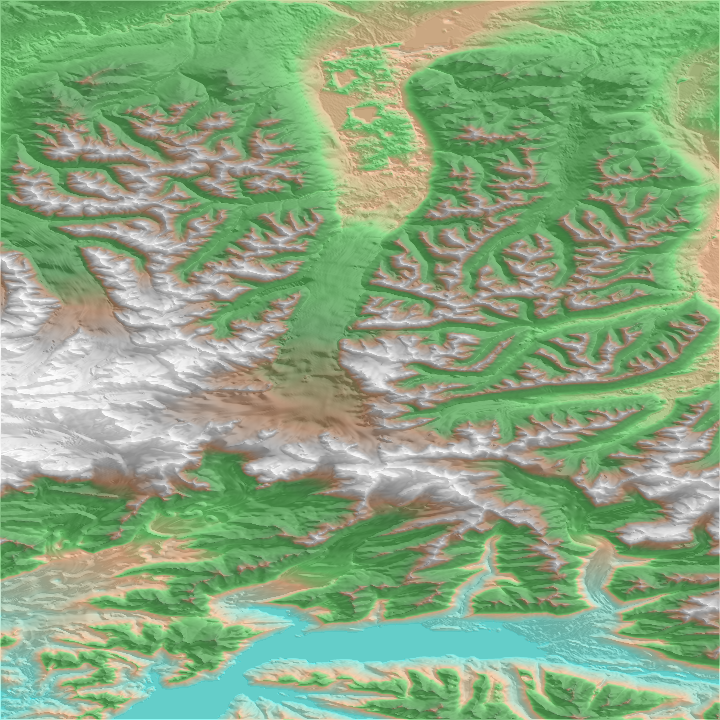

In [13]:
import planetary_computer
import xarray
import xrspatial
from datashader.transfer_functions import shade, stack
from datashader.colors import Elevation

signed_asset = planetary_computer.sign(item.assets["data"])
data = (
    xarray.open_rasterio(signed_asset.href)
    .squeeze()
    .drop("band")
    .coarsen({"y": 5, "x": 5})
    .mean()
)
hillshade = xrspatial.hillshade(data)
stack(shade(hillshade, cmap=["white", "gray"]), shade(data, cmap=Elevation, alpha=128))